In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import imutils
import shutil
from sklearn.utils import shuffle
import os

In [2]:
def crop_brain_contour(image):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 

    return new_image

In [3]:

TRINING_DIR = "C:\\Users\\X1\\Desktop\\master - S3\\image-mining\\data\\data\\Training"
TEST_DIR = "C:\\Users\\X1\\Desktop\\master - S3\\image-mining\\data\\data\\Testing"
image_size = 128
def readDataSet(dirr):
    data = []
   
    yes_path = os.path.join(dirr, "yes")
    for file in os.listdir(yes_path):
        image = cv2.imread(os.path.join(yes_path, file))
        img = crop_brain_contour(image)
        img = cv2.resize(img,(image_size,image_size))
        data.append((img,1))
        
    no_path = os.path.join(dirr, "no")
    for f in os.listdir(no_path):
        image = cv2.imread(os.path.join(no_path, f))
        img = crop_brain_contour(image)
        image = cv2.resize(img,(image_size,image_size))
        data.append((image,0))
      
    return data 
          
train_dataset  = shuffle(readDataSet(TRINING_DIR))
test_dataset = shuffle(readDataSet(TEST_DIR))
print("training dataset lenght : ",len(train_dataset) )
print("test dataset lenght : ",len(test_dataset) )

training dataset lenght :  2953
test dataset lenght :  409


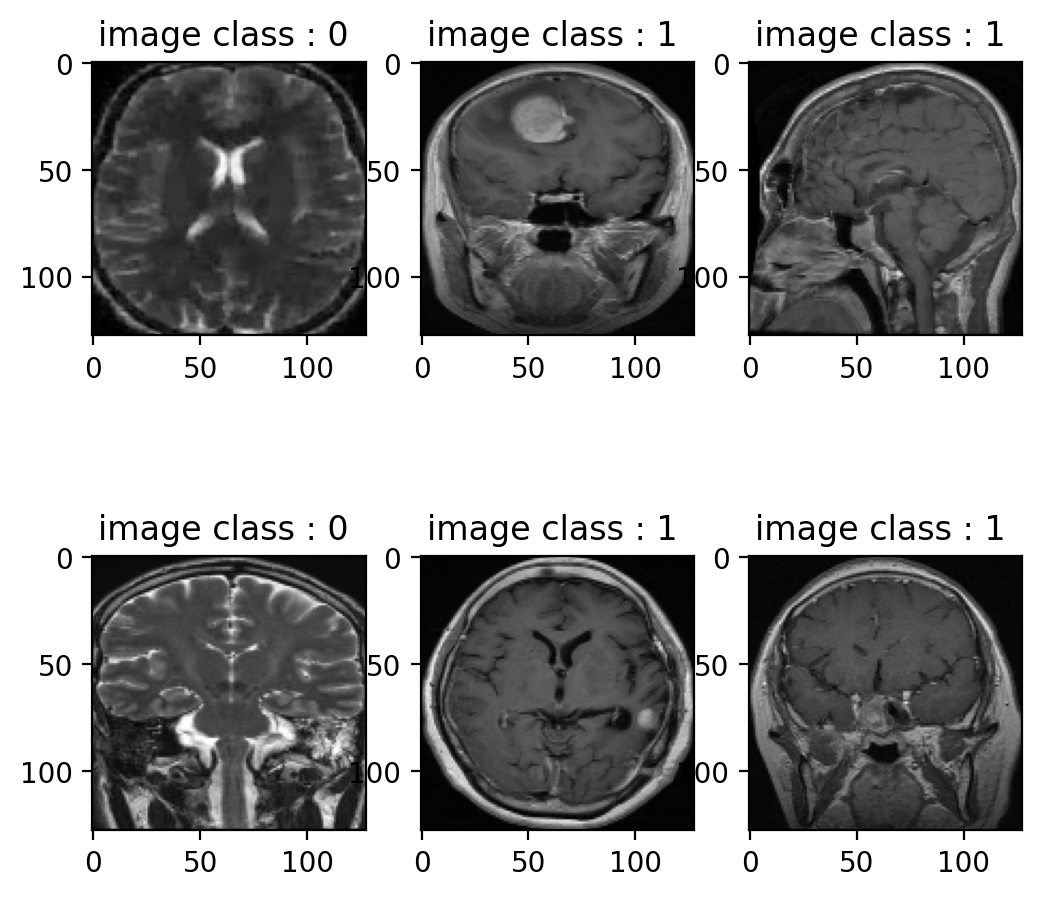

In [6]:
fig = plt.figure(figsize=(6, 6), dpi=200)
index = random.sample(range(len(train_dataset)), 6)
for i in range(6):
    ax1 = fig.add_subplot(2, 3, i+1)
    ax1.imshow(train_dataset[index[i]][0])
    ax1.set_title('image class : %s '% (train_dataset[index[i]][1]))


In [7]:
X_train = []
Y_train = []
for tupl in train_dataset:
    X_train.append(tupl[0])
    Y_train.append(tupl[1])
X_train = np.array(X_train)
Y_train = np.array(Y_train).reshape(-1)
    
X_test = []
Y_test = []
for tupl in test_dataset:
    X_test.append(tupl[0])
    Y_test.append(tupl[1])
X_test = np.array(X_test)
Y_test = np.array(Y_test).reshape(-1)


In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
#inception_model = InceptionV3(input_shape = (image_size,image_size, 3), include_top=False,weights = 'imagenet')
inception_model = tf.keras.applications.ResNet50(input_shape = (image_size,image_size, 3), include_top=False,weights = 'imagenet')

for layer in inception_model.layers:
       layer.trainable = False
        
inception_model.layers[-2].trainable = True;
inception_model.layers[-1].trainable = True;

x = layers.Flatten()(inception_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inception_model.input, x)


94773248/94765736 [==============================] - 60s 1us/step


In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [14]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'binary_crossentropy', 
                    metrics = ['accuracy'])
history = model.fit(X_train , Y_train,batch_size=64,epochs=20,validation_data=(X_test , Y_test))

Epoch 1/20
47/47 [==============================] - 116s 2s/step - loss: 15.3817 - accuracy: 0.9109 - val_loss: 53.7695 - val_accuracy: 0.4548
Epoch 2/20
47/47 [==============================] - 117s 2s/step - loss: 3.4930 - accuracy: 0.9482 - val_loss: 7.1491 - val_accuracy: 0.9169
Epoch 3/20
47/47 [==============================] - 108s 2s/step - loss: 1.8878 - accuracy: 0.9624 - val_loss: 27.3931 - val_accuracy: 0.5257
Epoch 4/20
47/47 [==============================] - 108s 2s/step - loss: 1.4331 - accuracy: 0.9692 - val_loss: 5.8542 - val_accuracy: 0.8729
Epoch 5/20
47/47 [==============================] - 125s 3s/step - loss: 0.6594 - accuracy: 0.9807 - val_loss: 3.3088 - val_accuracy: 0.9169
Epoch 6/20
47/47 [==============================] - 105s 2s/step - loss: 0.9194 - accuracy: 0.9773 - val_loss: 3.8996 - val_accuracy: 0.9315
Epoch 7/20
47/47 [==============================] - 118s 3s/step - loss: 1.1690 - accuracy: 0.9780 - val_loss: 2.8477 - val_accuracy: 0.9438
Epoch 8/20

In [15]:
scores = model.evaluate(X_test , Y_test)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

13/13 [==============================] - 10s 767ms/step - loss: 3.8729 - accuracy: 0.9511
Loss: 3.873
Accuracy: 0.951


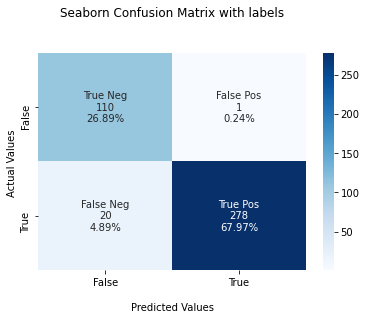

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)

cf_matrix = confusion_matrix(Y_test, np.uint8(Y_pred))
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()